In [298]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from prophet import Prophet
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split


In [299]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')


### Prepare Stock Data

In [382]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Remove unnecessary columns
filtered_stock_data_df =filtered_stock_data_df.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])

# Add a new column to calculate the price change
filtered_stock_data_df['Price Change'] =filtered_stock_data_df['Close'] - filtered_stock_data_df['Open']

# Remove the Open and Close columns
filtered_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]

filtered_stock_data_df


,Date,Stock Name,Price Change
0,2021-09-30,TSLA,-1.839996
1,2021-10-01,TSLA,-1.059998
2,2021-10-04,TSLA,-4.989990
3,2021-10-05,TSLA,-1.403351
4,2021-10-06,TSLA,2.183319
...,...,...,...
1255,2022-09-23,AMZN,-2.220001
1256,2022-09-26,AMZN,1.849998
1257,2022-09-27,AMZN,-2.789993
1258,2022-09-28,AMZN,3.630005


In [383]:
filtered_stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, 0 to 1259
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1260 non-null   object 
 1   Stock Name    1260 non-null   object 
 2   Price Change  1260 non-null   float64
dtypes: float64(1), object(2)
memory usage: 39.4+ KB


### Prepare Tweet Data

In [301]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [302]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [303]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


### Implement VADER Sentiment Analyzer on the Tweet data

In [304]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)
filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.125,0.763,0.113,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.954,0.046,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.921,0.079,0.5040,Positive
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.071,0.905,0.024,-0.5106,Negative
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.745,0.255,0.9369,Positive


In [305]:
train_df, test_df = train_test_split(filtered_tweet_data_df, test_size=0.2, random_state=42)
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis on the train and test data
train_df['VADER_Score'] = train_df['Tweet'].apply(analyze_sentiment)
test_df['VADER_Score'] = test_df['Tweet'].apply(analyze_sentiment)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment label function
test_df['VADER_Label'] = test_df['VADER_Score'].apply(vader_sentiment_label)

test_df


,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment,VADER_Score,VADER_Label
19100,2022-03-10,TSLA,"This @Tesla #FSD makes a sudden right turn, al...",0.071,0.929,0.000,-0.4574,Negative,-0.4574,Negative
32329,2021-11-07,TSLA,You have to wonder why Elon would take to Twit...,0.000,0.921,0.079,0.5267,Positive,0.5267,Positive
31744,2021-11-10,TSLA,I'll be that Cathie Wood bought some $TSLA tod...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
31244,2021-11-15,TSLA,Me looking forward to another week of Elon sel...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
24115,2022-01-18,TSLA,$AMC now the second most bought stock on the d...,0.000,0.937,0.063,0.5826,Positive,0.5826,Positive
...,...,...,...,...,...,...,...,...,...,...
22822,2022-01-27,TSLA,"Toni Sacconaghi, long-time $TSLA bear but high...",0.141,0.732,0.127,0.0337,Neutral,0.0337,Neutral
50940,2022-02-05,AMZN,$AMZN (daily) Prior support is now resistance....,0.000,0.722,0.278,0.4019,Positive,0.4019,Positive
12465,2022-05-09,TSLA,This day 8 years ago I bought my first Tesla! ...,0.000,0.907,0.093,0.5093,Positive,0.5093,Positive
24959,2022-01-11,TSLA,10yr TYs moving up in front of Powell’s testim...,0.074,0.831,0.094,0.1376,Positive,0.1376,Positive


In [306]:
# Calculate accuracy
accuracy = accuracy_score(test_df['Sentiment'], test_df['VADER_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [307]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.256980
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.256980
3,2021-09-30,PG,0.256980
4,2021-09-30,TSLA,0.251634
...,...,...,...
1763,2022-09-29,AMZN,0.086080
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.086080
1766,2022-09-29,PG,0.086080


In [308]:
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

new_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'Mean Compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')

merged_df.head()


,Date,Stock Name,Price Change,Mean Compound
0,2021-09-30 00:00:00,TSLA,-1.839996,0.251634
1,2021-10-01 00:00:00,TSLA,-1.059998,0.222412
2,2021-10-04 00:00:00,TSLA,-4.989990,0.151775
3,2021-10-05 00:00:00,TSLA,-1.403351,0.096692
4,2021-10-06 00:00:00,TSLA,2.183319,0.229846


### Scaling the Data

In [309]:
from sklearn.preprocessing import StandardScaler

# Inpmlement the StandardScaler
scaler = StandardScaler()

# Select the columns to be scaled
merged_df[['Mean Compound', 'Price Change']] = scaler.fit_transform(merged_df[['Mean Compound', 'Price Change']])
merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date

# Stadardized DataFrame
print(merged_df.head())

         Date Stock Name  Price Change  Mean Compound
0  2021-09-30       TSLA     -0.269702       0.234836
1  2021-10-01       TSLA     -0.141924       0.071836
2  2021-10-04       TSLA     -0.785731      -0.322168
3  2021-10-05       TSLA     -0.198172      -0.629412
4  2021-10-06       TSLA      0.389392       0.113304


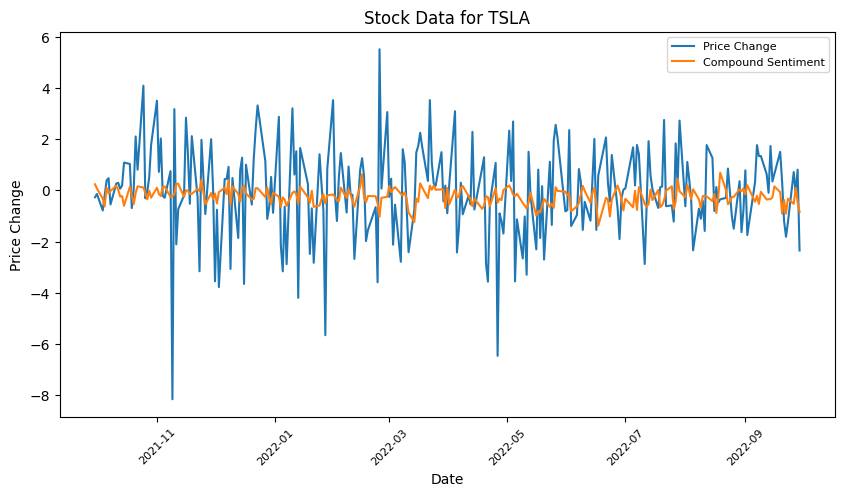

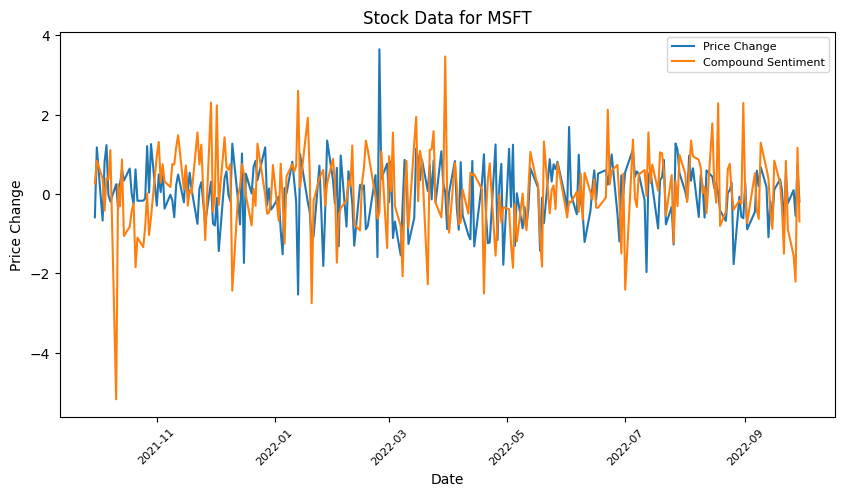

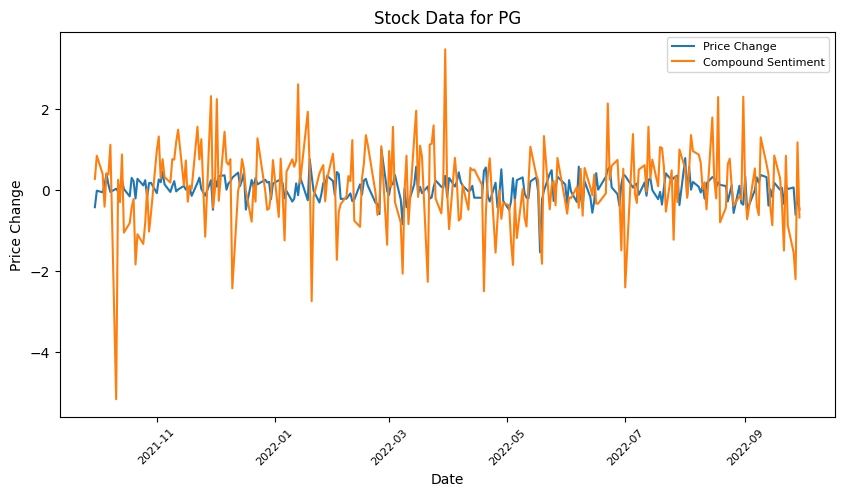

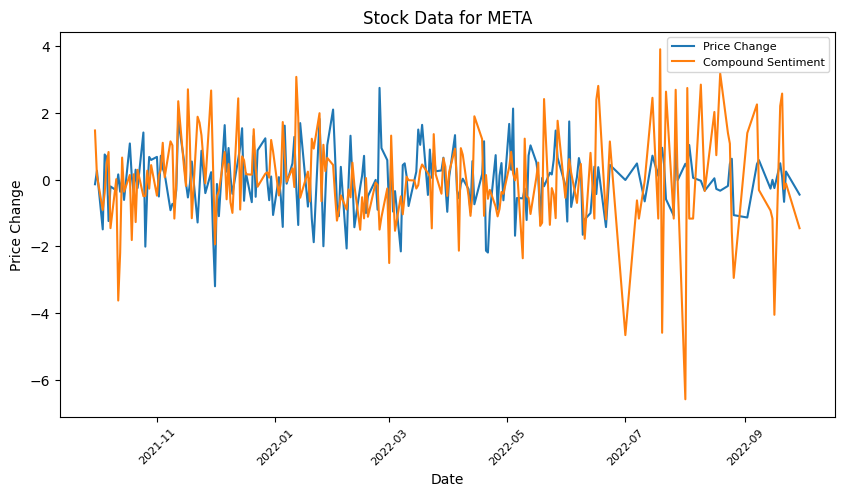

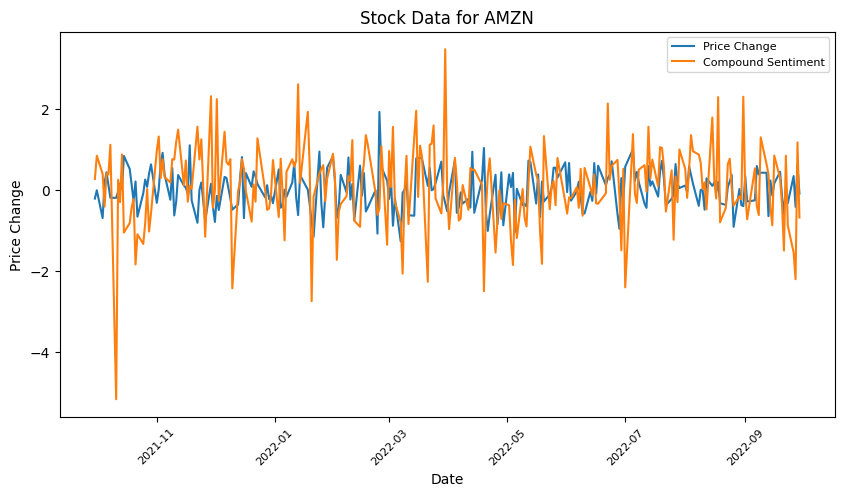

In [310]:
# Define the specific date range
# merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# start_date = '2022-07-01'
# end_date = '2022-09-30'

# merged_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
    stock_df = merged_df[merged_df['Stock Name'] == stock_name]
    
    # Plot the stock data
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df[['Price Change', 'Mean Compound']], label=stock_name)
    plt.title(f'Stock Data for {stock_name}', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.ylabel('Price Change', fontsize=10)
    plt.legend(['Price Change', 'Compound Sentiment'], fontsize=8)
    plt.show()

### Creating Stock Specific Dataframes

In [311]:
df_tsla = merged_df[merged_df['Stock Name'] == 'TSLA']
df_msft = merged_df[merged_df['Stock Name'] == 'MSFT']
df_pg = merged_df[merged_df['Stock Name'] == 'PG']
df_meta = merged_df[merged_df['Stock Name'] == 'META']
df_amzn = merged_df[merged_df['Stock Name'] == 'AMZN']

### Predict and Plot TSLA

In [312]:
# Prepare data for Prophet
tsla_sentiment_prophet_df = df_tsla.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
tsla_sentiment_prophet_df['ds'] = pd.to_datetime(tsla_sentiment_prophet_df['ds'])

# Check the DataFrame
tsla_sentiment_prophet_df

,ds,Stock Name,Price Change,y
0,2021-09-30,TSLA,-0.269702,0.234836
1,2021-10-01,TSLA,-0.141924,0.071836
2,2021-10-04,TSLA,-0.785731,-0.322168
3,2021-10-05,TSLA,-0.198172,-0.629412
4,2021-10-06,TSLA,0.389392,0.113304
...,...,...,...,...
247,2022-09-23,TSLA,-1.239512,-0.324375
248,2022-09-26,TSLA,0.716490,-0.528254
249,2022-09-27,TSLA,-0.115712,0.088839
250,2022-09-28,TSLA,0.806588,-0.444488


In [313]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(tsla_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:42 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.131629   -0.506742    0.216522
1   2021-10-01 -0.043642   -0.460629    0.358454
2   2021-10-04 -0.098060   -0.484262    0.301447
3   2021-10-05 -0.137925   -0.501043    0.279627
4   2021-10-06 -0.135527   -0.531259    0.254782
..         ...       ...         ...         ...
277 2022-10-25 -0.407181   -0.812345   -0.008663
278 2022-10-26 -0.404743   -0.794905    0.014995
279 2022-10-27 -0.405841   -0.792888    0.027419
280 2022-10-28 -0.317815   -0.739395    0.084436
281 2022-10-29 -0.183280   -0.582772    0.248576

[282 rows x 4 columns]


In [314]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,-0.131629
1,2021-10-01,-0.043642
2,2021-10-04,-0.098060
3,2021-10-05,-0.137925
4,2021-10-06,-0.135527
...,...,...
277,2022-10-25,-0.407181
278,2022-10-26,-0.404743
279,2022-10-27,-0.405841
280,2022-10-28,-0.317815


In [315]:
# Prepare data for Prophet
df_tsla = df_tsla.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_tsla['ds'] = pd.to_datetime(df_tsla['ds'])


In [316]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_tsla, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,TSLA,-0.269702,0.234836,-0.131629
1,2021-10-01,TSLA,-0.141924,0.071836,-0.043642
2,2021-10-04,TSLA,-0.785731,-0.322168,-0.098060
3,2021-10-05,TSLA,-0.198172,-0.629412,-0.137925
4,2021-10-06,TSLA,0.389392,0.113304,-0.135527
...,...,...,...,...,...
247,2022-09-23,TSLA,-1.239512,-0.324375,-0.294027
248,2022-09-26,TSLA,0.716490,-0.528254,-0.348326
249,2022-09-27,TSLA,-0.115712,0.088839,-0.388151
250,2022-09-28,TSLA,0.806588,-0.444488,-0.385713


In [317]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


In [318]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.276436   -2.592514    1.891846
1   2021-10-01 -0.185915   -2.357262    2.226711
2   2021-10-04  0.506109   -1.864156    2.710753
3   2021-10-05 -0.150971   -2.506664    2.057725
4   2021-10-06  0.237484   -2.193180    2.402390
..         ...       ...         ...         ...
277 2022-10-25 -0.307531   -2.475402    1.949416
278 2022-10-26  0.080729   -1.968754    2.373728
279 2022-10-27 -0.435570   -2.608804    2.020402
280 2022-10-28 -0.345243   -2.659279    2.000105
281 2022-10-29 -1.750335   -4.129302    0.400569

[282 rows x 4 columns]


c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


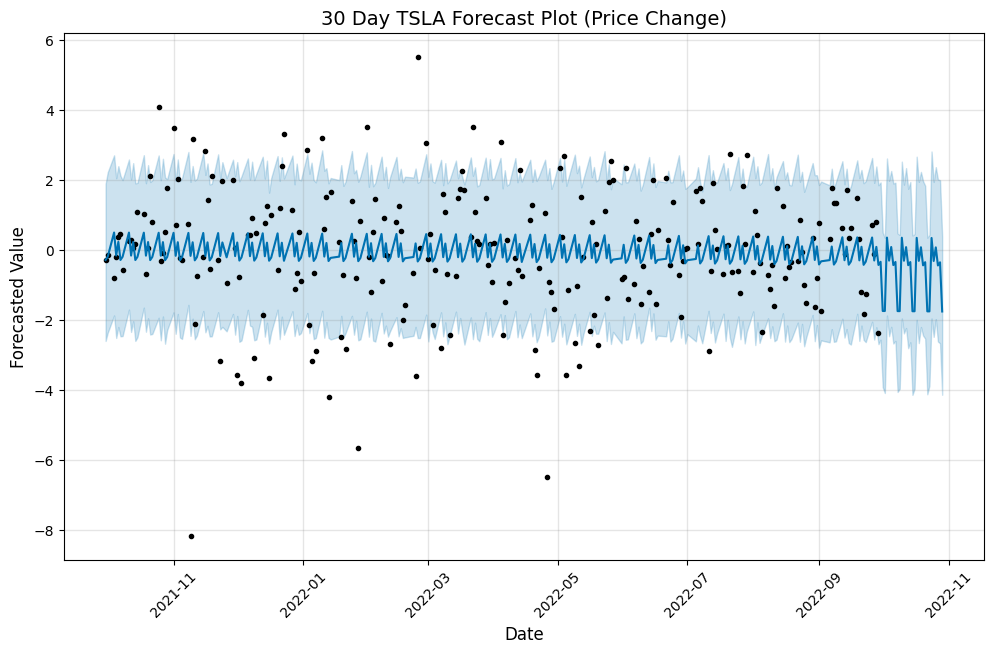

In [319]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day TSLA Forecast Plot (Price Change)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=10)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot MSFT

In [320]:
# Prepare data for Prophet
msft_sentiment_prophet_df = df_msft.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
msft_sentiment_prophet_df['ds'] = pd.to_datetime(msft_sentiment_prophet_df['ds'])

# Check the DataFrame
msft_sentiment_prophet_df

,ds,Stock Name,Price Change,y
252,2021-09-30,MSFT,-0.589146,0.264653
253,2021-10-01,MSFT,1.175181,0.837333
254,2021-10-04,MSFT,-0.671060,0.389848
255,2021-10-05,MSFT,0.803314,-0.420477
256,2021-10-06,MSFT,1.232513,0.401263
...,...,...,...,...
499,2022-09-23,MSFT,-0.233662,-0.886787
500,2022-09-26,MSFT,0.097250,-1.552027
501,2022-09-27,MSFT,-0.553108,-2.210359
502,2022-09-28,MSFT,0.729593,1.166483


In [321]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(msft_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.189427   -1.041170    1.445219
1   2021-10-01  0.009335   -1.236941    1.172639
2   2021-10-04 -0.047938   -1.377839    1.244405
3   2021-10-05  0.085830   -1.125530    1.368843
4   2021-10-06  0.171131   -1.010103    1.383980
..         ...       ...         ...         ...
277 2022-10-25  0.072213   -1.196889    1.320517
278 2022-10-26  0.157514   -1.010463    1.489214
279 2022-10-27  0.175562   -1.058893    1.515507
280 2022-10-28 -0.004529   -1.335580    1.168102
281 2022-10-29  0.174381   -1.007400    1.504954

[282 rows x 4 columns]


In [322]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.189427
1,2021-10-01,0.009335
2,2021-10-04,-0.047938
3,2021-10-05,0.085830
4,2021-10-06,0.171131
...,...,...
277,2022-10-25,0.072213
278,2022-10-26,0.157514
279,2022-10-27,0.175562
280,2022-10-28,-0.004529


In [323]:
# Prepare data for Prophet
df_msft = df_msft.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_msft['ds'] = pd.to_datetime(df_msft['ds'])


In [324]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_msft, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,MSFT,-0.589146,0.264653,0.189427
1,2021-10-01,MSFT,1.175181,0.837333,0.009335
2,2021-10-04,MSFT,-0.671060,0.389848,-0.047938
3,2021-10-05,MSFT,0.803314,-0.420477,0.085830
4,2021-10-06,MSFT,1.232513,0.401263,0.171131
...,...,...,...,...,...
247,2022-09-23,MSFT,-0.233662,-0.886787,-0.003293
248,2022-09-26,MSFT,0.097250,-1.552027,-0.060566
249,2022-09-27,MSFT,-0.553108,-2.210359,0.073202
250,2022-09-28,MSFT,0.729593,1.166483,0.158503


In [325]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

20:22:43 - cmdstanpy - INFO - Chain [1] start processing
20:22:43 - cmdstanpy - INFO - Chain [1] done processing


In [326]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.003871   -0.905012    1.000274
1   2021-10-01 -0.021043   -0.956573    1.028787
2   2021-10-04  0.037646   -0.953546    1.002434
3   2021-10-05 -0.048133   -0.997212    1.017430
4   2021-10-06  0.113666   -0.845494    1.087990
..         ...       ...         ...         ...
277 2022-10-25 -0.066582   -1.047652    0.949220
278 2022-10-26  0.095218   -0.887567    1.125553
279 2022-10-27 -0.014912   -1.014434    1.027151
280 2022-10-28 -0.039826   -0.996384    0.930617
281 2022-10-29 -0.308612   -1.267280    0.695959

[282 rows x 4 columns]


c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


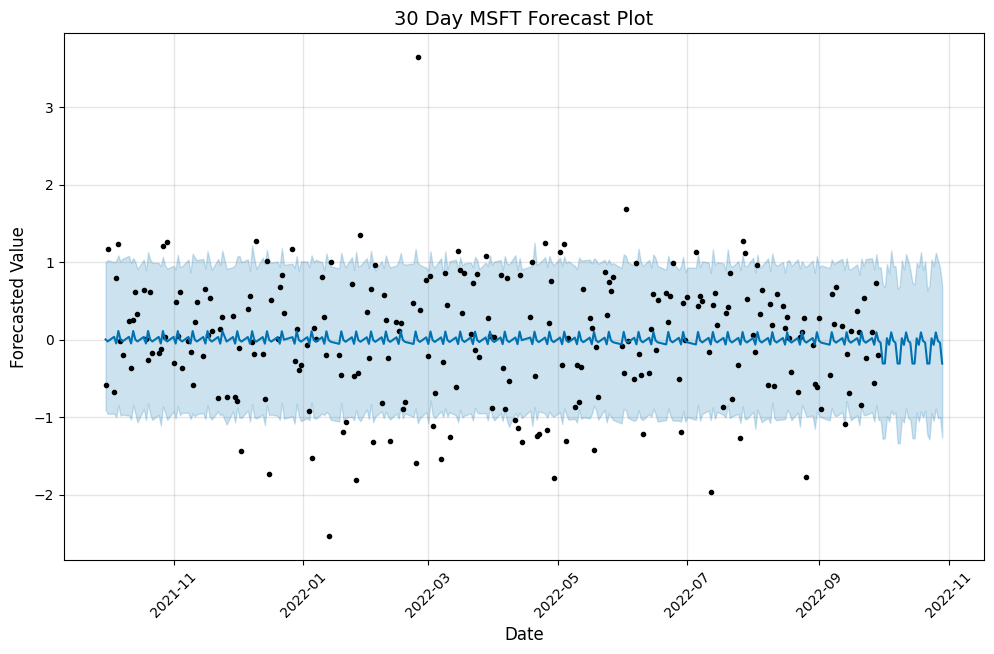

In [327]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day MSFT Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=10)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot PG

In [328]:
# Prepare data for Prophet
pg_sentiment_prophet_df = df_pg.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
pg_sentiment_prophet_df['ds'] = pd.to_datetime(pg_sentiment_prophet_df['ds'])

# Check the DataFrame
pg_sentiment_prophet_df

,ds,Stock Name,Price Change,y
504,2021-09-30,PG,-0.433521,0.264653
505,2021-10-01,PG,-0.025611,0.837333
506,2021-10-04,PG,-0.066569,0.389848
507,2021-10-05,PG,0.118547,-0.420477
508,2021-10-06,PG,0.392125,0.401263
...,...,...,...,...
751,2022-09-23,PG,0.015343,-0.886787
752,2022-09-26,PG,0.053021,-1.552027
753,2022-09-27,PG,-0.620277,-2.210359
754,2022-09-28,PG,-0.138649,1.166483


In [329]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(pg_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.189427   -1.088318    1.385919
1   2021-10-01  0.009335   -1.219996    1.331143
2   2021-10-04 -0.047938   -1.280663    1.154950
3   2021-10-05  0.085830   -1.273140    1.446116
4   2021-10-06  0.171131   -1.109457    1.370777
..         ...       ...         ...         ...
277 2022-10-25  0.072213   -1.210691    1.275775
278 2022-10-26  0.157514   -1.134669    1.285080
279 2022-10-27  0.175562   -1.121520    1.481097
280 2022-10-28 -0.004529   -1.306992    1.336823
281 2022-10-29  0.174381   -1.258370    1.369746

[282 rows x 4 columns]


In [330]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.189427
1,2021-10-01,0.009335
2,2021-10-04,-0.047938
3,2021-10-05,0.085830
4,2021-10-06,0.171131
...,...,...
277,2022-10-25,0.072213
278,2022-10-26,0.157514
279,2022-10-27,0.175562
280,2022-10-28,-0.004529


In [331]:
# Prepare data for Prophet
df_pg = df_pg.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_pg['ds'] = pd.to_datetime(df_pg['ds'])


In [332]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_pg, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,PG,-0.433521,0.264653,0.189427
1,2021-10-01,PG,-0.025611,0.837333,0.009335
2,2021-10-04,PG,-0.066569,0.389848,-0.047938
3,2021-10-05,PG,0.118547,-0.420477,0.085830
4,2021-10-06,PG,0.392125,0.401263,0.171131
...,...,...,...,...,...
247,2022-09-23,PG,0.015343,-0.886787,-0.003293
248,2022-09-26,PG,0.053021,-1.552027,-0.060566
249,2022-09-27,PG,-0.620277,-2.210359,0.073202
250,2022-09-28,PG,-0.138649,1.166483,0.158503


In [333]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


In [334]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.073715   -0.305906    0.436885
1   2021-10-01  0.090272   -0.288925    0.436141
2   2021-10-04  0.098815   -0.267569    0.459634
3   2021-10-05 -0.000292   -0.351750    0.393600
4   2021-10-06  0.095086   -0.270865    0.450482
..         ...       ...         ...         ...
277 2022-10-25 -0.075965   -0.452547    0.276094
278 2022-10-26  0.019412   -0.329886    0.424131
279 2022-10-27 -0.003334   -0.364990    0.348267
280 2022-10-28  0.013222   -0.353929    0.396714
281 2022-10-29 -0.297053   -0.659234    0.062651

[282 rows x 4 columns]


c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


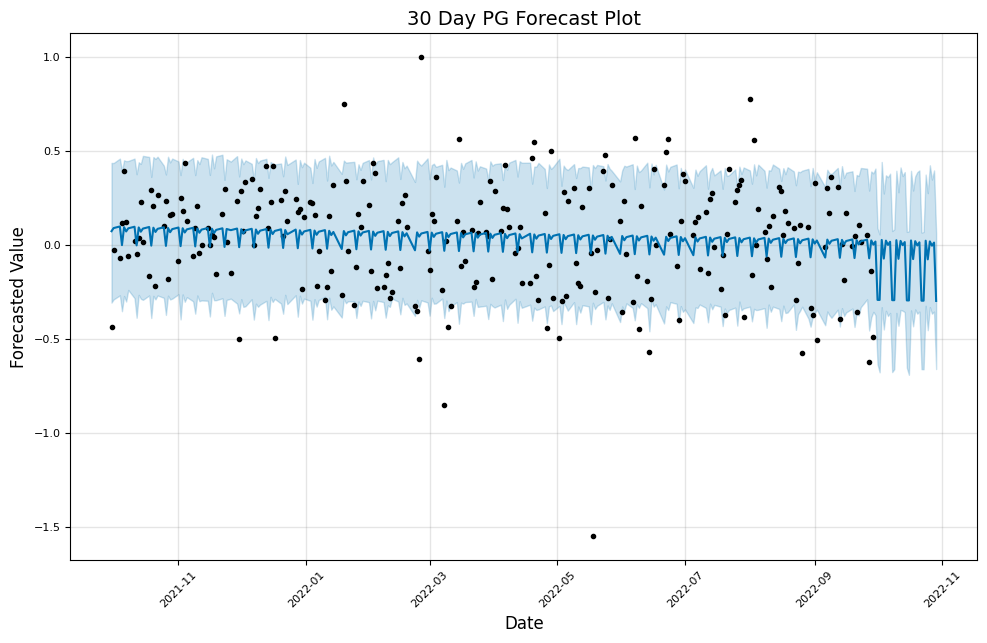

In [335]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day PG Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=8)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot META

In [336]:
# Prepare data for Prophet
meta_sentiment_prophet_df = df_meta.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
meta_sentiment_prophet_df['ds'] = pd.to_datetime(meta_sentiment_prophet_df['ds'])

# Check the DataFrame
meta_sentiment_prophet_df

,ds,Stock Name,Price Change,y
756,2021-09-30,META,-0.141924,1.466610
757,2021-10-01,META,0.261074,0.119182
758,2021-10-04,META,-1.491789,-0.911233
759,2021-10-05,META,0.749251,-0.402942
760,2021-10-06,META,0.670621,0.481604
...,...,...,...,...
970,2022-09-19,META,0.487140,2.198612
971,2022-09-20,META,0.082507,2.570656
972,2022-09-21,META,-0.667783,-0.280193
973,2022-09-22,META,0.239774,-0.120480


In [337]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(meta_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

20:22:44 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.176806   -1.482417    1.950357
1   2021-10-01  0.044021   -1.638458    1.860155
2   2021-10-04  0.052238   -1.669665    1.912524
3   2021-10-05  0.165142   -1.700447    1.937652
4   2021-10-06  0.025288   -1.687516    1.800539
..         ...       ...         ...         ...
244 2022-10-25 -0.078389   -1.983216    1.581463
245 2022-10-26 -0.218237   -2.086576    1.495745
246 2022-10-27 -0.071157   -1.895683    1.663854
247 2022-10-28 -0.203936   -1.996567    1.467990
248 2022-10-29  0.645128   -1.121126    2.405381

[249 rows x 4 columns]


In [338]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.176806
1,2021-10-01,0.044021
2,2021-10-04,0.052238
3,2021-10-05,0.165142
4,2021-10-06,0.025288
...,...,...
244,2022-10-25,-0.078389
245,2022-10-26,-0.218237
246,2022-10-27,-0.071157
247,2022-10-28,-0.203936


In [339]:
# Prepare data for Prophet
df_meta = df_meta.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_meta['ds'] = pd.to_datetime(df_meta['ds'])


In [340]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_meta, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,META,-0.141924,1.466610,0.176806
1,2021-10-01,META,0.261074,0.119182,0.044021
2,2021-10-04,META,-1.491789,-0.911233,0.052238
3,2021-10-05,META,0.749251,-0.402942,0.165142
4,2021-10-06,META,0.670621,0.481604,0.025288
...,...,...,...,...,...
214,2022-09-19,META,0.487140,2.198612,-0.169290
215,2022-09-20,META,0.082507,2.570656,-0.056381
216,2022-09-21,META,-0.667783,-0.280193,-0.196229
217,2022-09-22,META,0.239774,-0.120480,-0.049149


In [341]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing


In [342]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.045683   -1.238385    1.063958
1   2021-10-01 -0.087183   -1.203130    1.048972
2   2021-10-04  0.171385   -0.974078    1.303991
3   2021-10-05 -0.051580   -1.191754    1.078609
4   2021-10-06 -0.036081   -1.204357    1.058928
..         ...       ...         ...         ...
244 2022-10-25 -0.052798   -1.178306    1.117997
245 2022-10-26 -0.037304   -1.209975    1.152893
246 2022-10-27 -0.046920   -1.202852    1.136464
247 2022-10-28 -0.088425   -1.310639    1.085703
248 2022-10-29 -0.794520   -1.913001    0.479587

[249 rows x 4 columns]


### Predict and Plot AMZN

In [343]:
# Prepare data for Prophet
amzn_sentiment_prophet_df = df_amzn.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
amzn_sentiment_prophet_df['ds'] = pd.to_datetime(amzn_sentiment_prophet_df['ds'])

# Check the DataFrame
amzn_sentiment_prophet_df

,ds,Stock Name,Price Change,y
975,2021-09-30,AMZN,-0.221868,0.264653
976,2021-10-01,AMZN,-0.015375,0.837333
977,2021-10-04,AMZN,-0.702266,0.389848
978,2021-10-05,AMZN,0.166874,-0.420477
979,2021-10-06,AMZN,0.428820,0.401263
...,...,...,...,...
1222,2022-09-23,AMZN,-0.331954,-0.886787
1223,2022-09-26,AMZN,0.334788,-1.552027
1224,2022-09-27,AMZN,-0.425330,-2.210359
1225,2022-09-28,AMZN,0.626387,1.166483


In [344]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(amzn_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.189427   -0.996768    1.415135
1   2021-10-01  0.009335   -1.265148    1.249204
2   2021-10-04 -0.047938   -1.299426    1.256199
3   2021-10-05  0.085830   -1.100084    1.189862
4   2021-10-06  0.171131   -1.110678    1.433049
..         ...       ...         ...         ...
277 2022-10-25  0.072213   -1.186150    1.308180
278 2022-10-26  0.157514   -1.135140    1.497661
279 2022-10-27  0.175562   -1.042475    1.424397
280 2022-10-28 -0.004529   -1.249946    1.262583
281 2022-10-29  0.174381   -1.084775    1.345498

[282 rows x 4 columns]


In [345]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.189427
1,2021-10-01,0.009335
2,2021-10-04,-0.047938
3,2021-10-05,0.085830
4,2021-10-06,0.171131
...,...,...
277,2022-10-25,0.072213
278,2022-10-26,0.157514
279,2022-10-27,0.175562
280,2022-10-28,-0.004529


In [346]:
# Prepare data for Prophet
df_amzn = df_amzn.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_amzn['ds'] = pd.to_datetime(df_amzn['ds'])


In [347]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_amzn, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,AMZN,-0.221868,0.264653,0.189427
1,2021-10-01,AMZN,-0.015375,0.837333,0.009335
2,2021-10-04,AMZN,-0.702266,0.389848,-0.047938
3,2021-10-05,AMZN,0.166874,-0.420477,0.085830
4,2021-10-06,AMZN,0.428820,0.401263,0.171131
...,...,...,...,...,...
247,2022-09-23,AMZN,-0.331954,-0.886787,-0.003293
248,2022-09-26,AMZN,0.334788,-1.552027,-0.060566
249,2022-09-27,AMZN,-0.425330,-2.210359,0.073202
250,2022-09-28,AMZN,0.626387,1.166483,0.158503


In [348]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing


In [349]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.000713   -0.582507    0.621832
1   2021-10-01 -0.064567   -0.658346    0.565955
2   2021-10-04 -0.014526   -0.651400    0.558500
3   2021-10-05  0.008964   -0.595113    0.650263
4   2021-10-06  0.005185   -0.626029    0.635328
..         ...       ...         ...         ...
277 2022-10-25  0.065917   -0.579893    0.696824
278 2022-10-26  0.062136   -0.578092    0.690223
279 2022-10-27  0.058708   -0.570127    0.692584
280 2022-10-28 -0.006573   -0.626501    0.619096
281 2022-10-29 -0.058459   -0.726898    0.535311

[282 rows x 4 columns]


c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


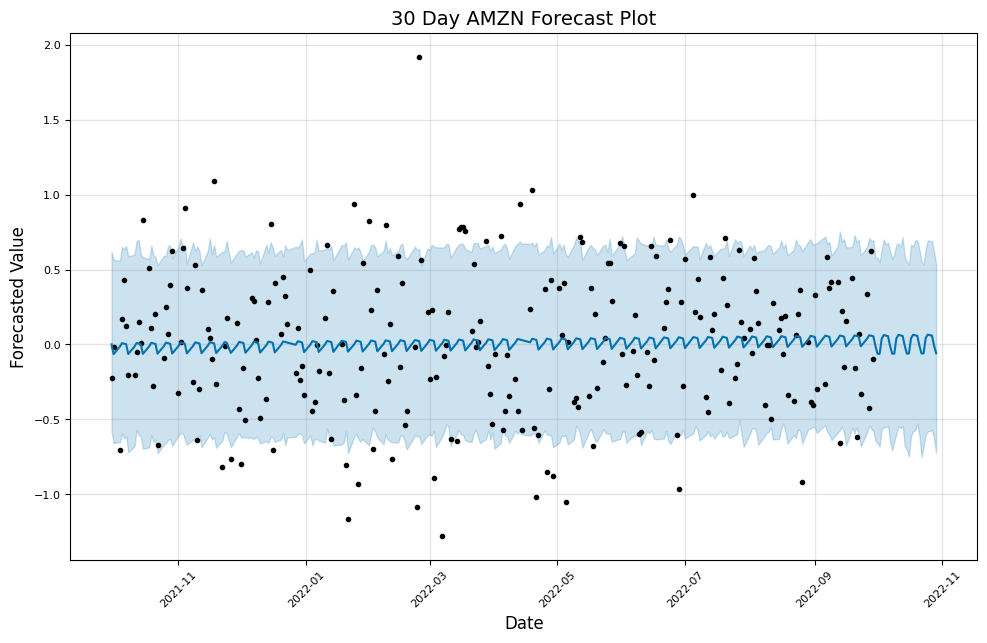

In [350]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day AMZN Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=8)

plt.show()

### Change to Closing Price

In [414]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]
filtered_stock_data_df.fillna(0)

# Remove unnecessary columns
# filtered_stock_data_df =filtered_stock_data_df.drop(columns=['High', 'Low', 'Open', 'Adj Close', 'Volume'])

# Add a new column to calculate the price change
# filtered_stock_data_df['Price Change'] =filtered_stock_data_df['Close'] - filtered_stock_data_df['Open']

# Remove the Open and Close columns
# filtered_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Close']]

filtered_stock_data_df


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
1255,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,AMZN
1256,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,AMZN
1257,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,AMZN
1258,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,AMZN


In [416]:
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

new_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'Mean Compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')

merged_df.head()


,Date,Stock Name,Open,High,Low,Close,Adj Close,Volume,Mean Compound
0,2021-09-30 00:00:00,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.251634
1,2021-10-01 00:00:00,TSLA,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.222412
2,2021-10-04 00:00:00,TSLA,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.151775
3,2021-10-05 00:00:00,TSLA,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.096692
4,2021-10-06 00:00:00,TSLA,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.229846


In [437]:
from sklearn.preprocessing import StandardScaler

# Inpmlement the StandardScaler
scaler = StandardScaler()

# Select the columns to be scaled
scaler.fit_transform(merged_df[['Mean Compound', 'Close']])
# merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date

# Stadardized DataFrame
print(merged_df.head())

         Date Stock Name     Close  Mean Compound
0  2021-09-30       TSLA  0.418260       0.234836
1  2021-10-01       TSLA  0.417160       0.071836
2  2021-10-04       TSLA  0.443847      -0.322168
3  2021-10-05       TSLA  0.439871      -0.629412
4  2021-10-06       TSLA  0.449006       0.113304


In [438]:
df_tsla = merged_df[merged_df['Stock Name'] == 'TSLA']
df_msft = merged_df[merged_df['Stock Name'] == 'MSFT']
df_pg = merged_df[merged_df['Stock Name'] == 'PG']
df_meta = merged_df[merged_df['Stock Name'] == 'META']
df_amzn = merged_df[merged_df['Stock Name'] == 'AMZN']

### Predict and Plot TSLA

In [439]:
# Prepare sentiment data for Prophet
tsla_sentiment_prophet_df = df_tsla.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
tsla_sentiment_prophet_df['ds'] = pd.to_datetime(tsla_sentiment_prophet_df['ds'])

# Check the DataFrame
tsla_sentiment_prophet_df

,ds,Stock Name,Close,y
0,2021-09-30,TSLA,0.418260,0.234836
1,2021-10-01,TSLA,0.417160,0.071836
2,2021-10-04,TSLA,0.443847,-0.322168
3,2021-10-05,TSLA,0.439871,-0.629412
4,2021-10-06,TSLA,0.449006,0.113304
...,...,...,...,...
247,2022-09-23,TSLA,0.631880,-0.324375
248,2022-09-26,TSLA,0.640508,-0.528254
249,2022-09-27,TSLA,0.728435,0.088839
250,2022-09-28,TSLA,0.790224,-0.444488


In [440]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(tsla_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

21:06:31 - cmdstanpy - INFO - Chain [1] start processing
21:06:31 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.131277   -0.509288    0.272013
1   2021-10-01 -0.043458   -0.461398    0.348718
2   2021-10-04 -0.097733   -0.504589    0.299747
3   2021-10-05 -0.137577   -0.553908    0.268057
4   2021-10-06 -0.135210   -0.542044    0.287116
..         ...       ...         ...         ...
277 2022-10-25 -0.405000   -0.801895   -0.026657
278 2022-10-26 -0.402566   -0.796267   -0.018357
279 2022-10-27 -0.403671   -0.777021    0.019813
280 2022-10-28 -0.315787   -0.697139    0.059124
281 2022-10-29 -0.181288   -0.561033    0.245782

[282 rows x 4 columns]


In [441]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,-0.131277
1,2021-10-01,-0.043458
2,2021-10-04,-0.097733
3,2021-10-05,-0.137577
4,2021-10-06,-0.135210
...,...,...
277,2022-10-25,-0.405000
278,2022-10-26,-0.402566
279,2022-10-27,-0.403671
280,2022-10-28,-0.315787


In [442]:
# Prepare data for Prophet
df_tsla = df_tsla.rename(columns={'Date': 'ds', 'Close': 'y'})

# Convert 'ds' to datetime
df_tsla['ds'] = pd.to_datetime(df_tsla['ds'])


In [443]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_tsla, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,TSLA,0.418260,0.234836,-0.131277
1,2021-10-01,TSLA,0.417160,0.071836,-0.043458
2,2021-10-04,TSLA,0.443847,-0.322168,-0.097733
3,2021-10-05,TSLA,0.439871,-0.629412,-0.137577
4,2021-10-06,TSLA,0.449006,0.113304,-0.135210
...,...,...,...,...,...
247,2022-09-23,TSLA,0.631880,-0.324375,-0.292583
248,2022-09-26,TSLA,0.640508,-0.528254,-0.346659
249,2022-09-27,TSLA,0.728435,0.088839,-0.386437
250,2022-09-28,TSLA,0.790224,-0.444488,-0.384004


21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Performance Report:
Mean Absolute Error (MAE): 72.4989
Mean Squared Error (MSE): 7325.7860
Root Mean Squared Error (RMSE): 85.5908
R-squared (R²): -0.0734


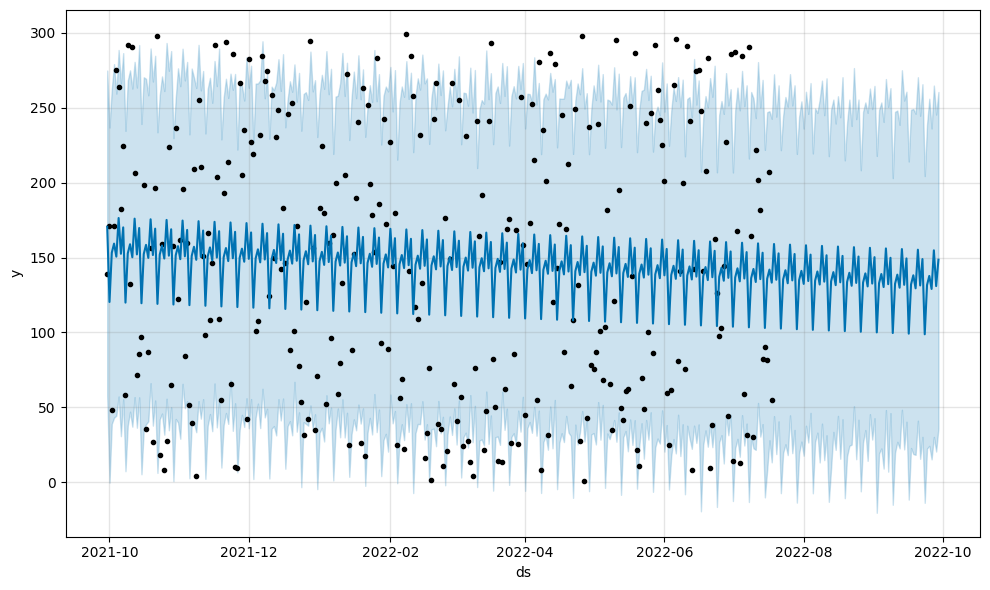

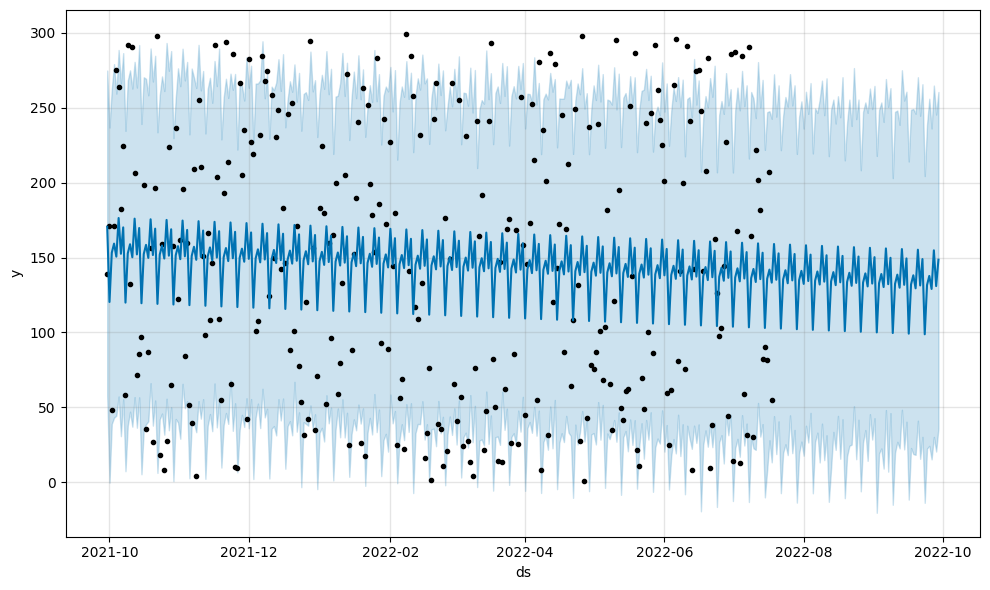

In [444]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming this is your DataFrame (replace this with actual data)
data = {
    'ds': pd.date_range(start='2021-09-30', periods=365),
    'Stock Name': ['TSLA'] * 365,
    'y': np.random.rand(365) * 300,  # Replace with actual stock prices
    'Mean Compound': np.random.rand(365),
    'Sentiment': np.random.rand(365)
}

df = pd.DataFrame(data)

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size][['ds', 'y']]  # We use only 'ds' and 'y' columns for Prophet
test_df = df[train_size:][['ds', 'y']]

# Initialize the Prophet model
model = Prophet()

# Train the model
model.fit(train_df)

# Make future dataframe (for prediction) based on the testing set size
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Predict using the Prophet model
forecast = model.predict(future)

# Evaluate model performance on the test set
y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values

# Calculate performance metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print accuracy and performance report
print("Performance Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualize the forecast
model.plot(forecast)

21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Performance Report:
Mean Absolute Error (MAE): 0.9351
Mean Squared Error (MSE): 1.0033
Root Mean Squared Error (RMSE): 1.0017
R-squared (R²): -30.0501


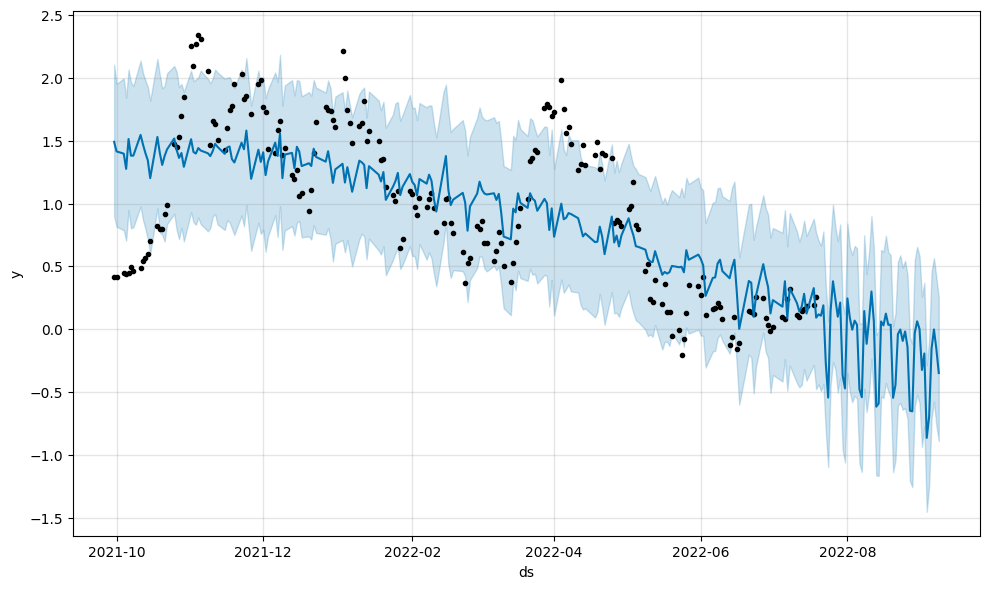

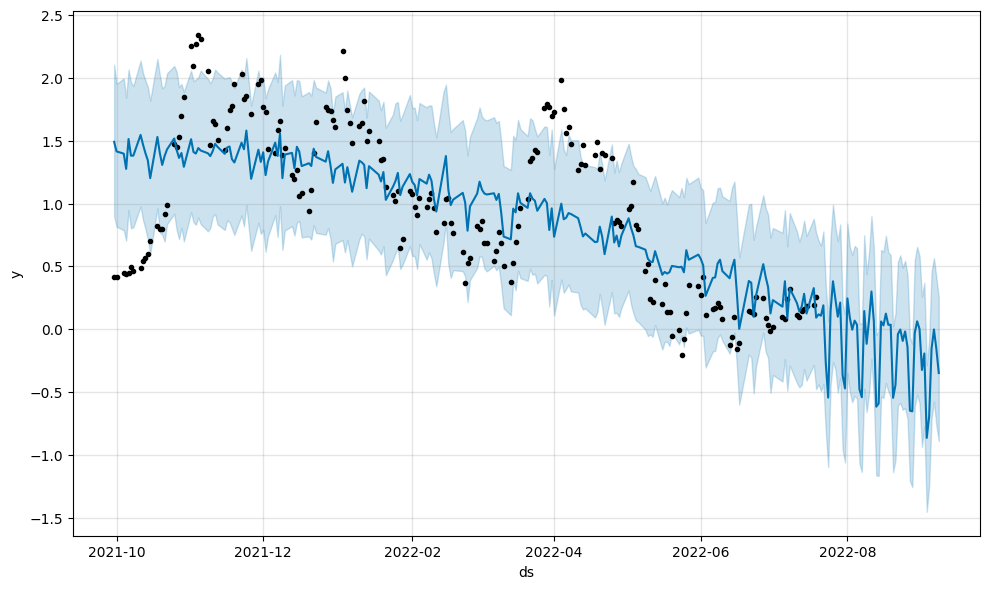

In [445]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Example DataFrame (replace this with your actual stock data)
# data = {
#    'ds': pd.date_range(start='2021-09-30', periods=365),
#    'Stock Name': ['TSLA'] * 365,
#    'y': np.random.rand(365) * 365,  # Replace with actual stock prices
#    'Mean Compound': np.random.rand(365),
#    'Sentiment': np.random.rand(365)
#}

df = merged_data

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size][['ds', 'y', 'Mean Compound']]
test_df = df[train_size:][['ds', 'y',  'Mean Compound']]

# Initialize the Prophet model
model = Prophet()

# Add 'Mean Compound' and 'Sentiment' as regressors
model.add_regressor('Mean Compound')
# model.add_regressor('Sentiment')

# Train the model on the training data
model.fit(train_df)

# Create future dataframe for the forecast period, including the regressors
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Make sure to include the regressors in the future DataFrame
future['Mean Compound'] = df['Mean Compound']
# future['Sentiment'] = df['Sentiment']

# Predict using the Prophet model
forecast = model.predict(future)

# Evaluate model performance on the test set
y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values

# Calculate performance metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print performance report
print("Performance Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualize the forecast
model.plot(forecast)


21:07:12 - cmdstanpy - INFO - Chain [1] start processing
21:07:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Mean Absolute Error (MAE): 0.9993577977814144


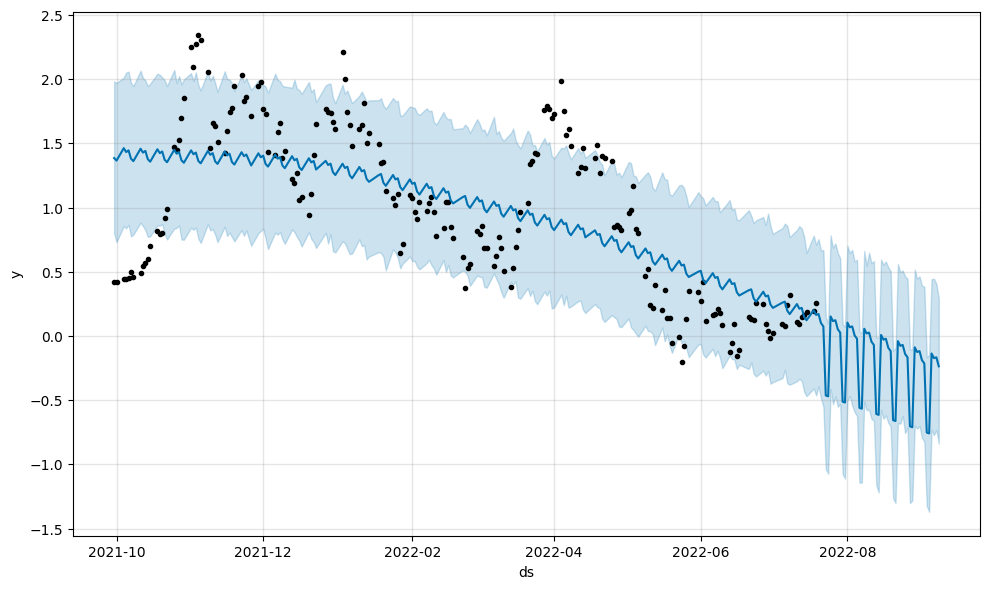

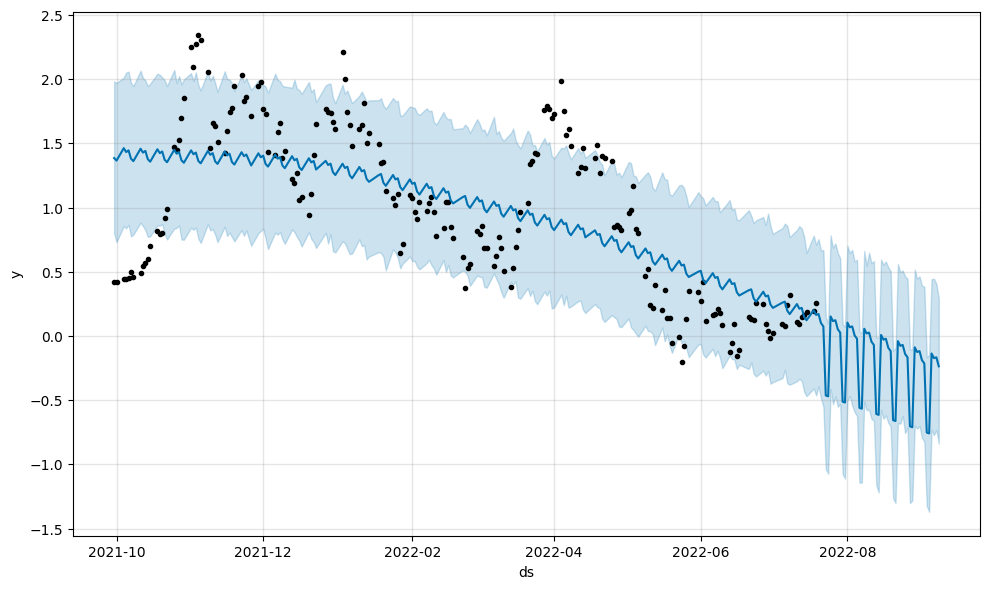

In [446]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Example time series DataFrame
# Ensure that your DataFrame has columns 'ds' (date) and 'y' (value)
df = merged_data

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize the Prophet model
model = Prophet()

# Train the model
model.fit(train_df)

# Make future dataframe (for prediction) based on the testing set size
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Predict using the Prophet model
forecast = model.predict(future)

# Evaluate model performance on the test set
y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Visualize the forecast
model.plot(forecast)



In [448]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming this is your actual DataFrame with real stock prices
df = merged_data

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize the Prophet model
model = Prophet()
model.add_regressor('Mean Compound')
model.add_regressor('Sentiment')

# Train the model with the additional regressors
model.fit(train_df[['ds', 'y', 'Mean Compound', 'Sentiment']])

# Make future dataframe (for prediction) based on the testing set size
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Ensure that the future dataframe includes the regressors for prediction
future = future.merge(df[['ds', 'Mean Compound', 'Sentiment']], on='ds', how='left')

# Predict using the Prophet model
forecast = model.predict(future)

# Evaluate model performance on the test set
y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values

# Calculate performance metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print accuracy and performance report
print("Performance Report:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualize the forecast
model.plot(forecast)


21:07:44 - cmdstanpy - INFO - Chain [1] start processing
21:07:44 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found NaN in column 'Mean Compound'

In [449]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

21:07:49 - cmdstanpy - INFO - Chain [1] start processing
21:07:49 - cmdstanpy - INFO - Chain [1] done processing


In [450]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  1.425548    0.758414    2.033448
1   2021-10-01  1.406572    0.772894    2.077005
2   2021-10-04  1.493568    0.906823    2.132884
3   2021-10-05  1.441287    0.772648    2.021482
4   2021-10-06  1.461937    0.831954    2.087019
..         ...       ...         ...         ...
277 2022-10-25  0.407000   -0.227105    1.029040
278 2022-10-26  0.428042   -0.217735    1.081701
279 2022-10-27  0.372215   -0.276369    1.039306
280 2022-10-28  0.353630   -0.325396    1.021240
281 2022-10-29  1.028020    0.386491    1.653047

[282 rows x 4 columns]


c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\justi\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


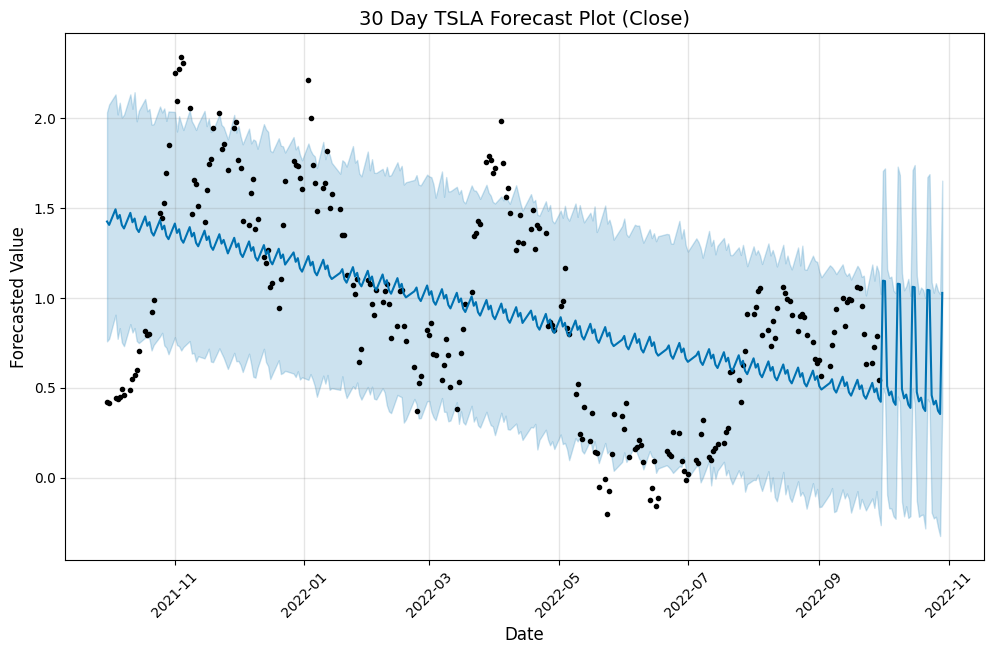

In [451]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day TSLA Forecast Plot (Close)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=10)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()